In [1]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

In [ ]:
### Installation of the necessary packages

#general packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets as ds
from scipy import stats
from sklearn.linear_model import Lasso, LassoCV

#classifiers
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

#other imports
from worcliver.load_data import load_data

### Inspecting the data
data = load_data() #loading the data

#set the number samples for the training set (80%) and test set (20%)
amount_in_training = round(len(data.index)*0.8)
amount_in_test = round(len(data.index)*0.2)

#split the data into training data and test data in order to make sure choices are only based on training set
training_data, test_data = model_selection.train_test_split(data, test_size=(amount_in_test) / len(data), random_state=42)

#checking the lengths of training and test set
print(f'Training + validation: {len(training_data)} samples + {len(test_data)} samples.')
print(f'Total number of dataset samples: {len(training_data)+len(test_data)}')

#check number of samples and features: only on the training set!
print(f'The number of training set samples: {len(training_data.index)}')
print(f'The number of features in training set: {len(training_data.columns)}')

training_data_df = pd.DataFrame(training_data) 

#find number of categorical and numerical features in training set 
cat_cols = training_data_df.select_dtypes(include=["object"]).columns
num_cols = training_data_df.select_dtypes(include=["number"]).columns
print(f"categorical columns: {len(cat_cols)}")
print(f'numerical columns: {len(num_cols)}')

#find samples without any variation
no_variation_samples = 0
for sample in training_data.index:
    data_sample = training_data.drop(columns=['label']) # first drop the label 
    if data_sample.loc[sample].max() == data_sample.loc[sample].min(): #check for variation
        no_variation_samples += 1
print(f'samples with no variation: {no_variation_samples}')

#find features without any variation       
no_variation_col = 0
for feature in training_data.columns:
    if training_data[feature].max() == training_data[feature].min(): #check for variation
        no_variation_col += 1
print(f'features with no variation: {no_variation_col}')

#check the number of malignant and beningn samples in the training dataset
data_df = pd.DataFrame(data)
label = data_df[['label']]
malignant_count = (label == "malignant").sum()
benign_count = (label == "benign").sum()

print(f'Class Distribution: malignant {malignant_count} and benign {benign_count}')


Training + validation: 149 samples + 37 samples.
Total number of dataset samples: 186
The number of training set samples: 149
The number of columns in training set: 494
categorical columns: 1
numerical columns: 493
samples with no variation: 0
features with no variation: 19
Class Distribution: malignant label    94
dtype: int64 and benign label    92
dtype: int64


## Preprocessing
The function definitions of the functions used for preprocessing.

In [ ]:
def determining_labels(df):
    """Extracts and binarizes labels, and removes the label column from the input DataFrame.
    
    Input: dataframe with the raw data
    Output: the binary labels, in which 1 is malignant, and 0 is benign
    """
    
    if 'label' not in df.columns:
        raise KeyError("Expected 'label' column not found in DataFrame.") 

    label_column = df['label'].copy()

    #drop label from the input dataframe without modifying the original
    df.drop(columns=['label'], inplace=True)

    #creating binary labels to construct the classifiers
    label_binary = label_column.map({'malignant': 1, 'benign': 0})
    return label_binary

def handling_missing_data(training_data):
    '''Searches for NaN in the training data, and replaces them with the mean value, 
    returns the training data without missing NaNs.
    
    Input: dataframe with the raw data
    Output: dataframe in which the missing values are replaced
    '''
    data_training = pd.DataFrame(training_data) 

    #if missing data is stored as NaN, replace with the mean
    nan_check = data_training.isna()
    nan_counts = nan_check.sum() #count number of NaNs 
    missing_data_features = nan_counts[nan_counts > 0].index.tolist()

    #loop over the features with missing data and replace the value with the mean 
    for feature in missing_data_features:
        mean_value = data_training[feature].mean()
        data_training[feature].fillna(mean_value, inplace=True)
    
    # N.B. if missing data is stored as 0, don't handle this as missing data: values in Radiomics can also be determined as 0

    return data_training

def feature_variance(data_training):
    '''Check for variance within features and return feature list without variance.
    
    Input: dataframe with the data in which the missing data is replaced
    Output: list of features in which there is no variation
    '''
    features_no_variation = []

    for feature in data_training.columns:
        if data_training[feature].max() == data_training[feature].min(): #checks if the feature has zero variance
            features_no_variation.append(feature)
    return features_no_variation
  
def delete_no_varation(data_training, features_no_variation):
    '''Removes all features from the training data that have no variance.
    
    Input: dataframe with the data in which the missing data is replaced &
           list of features in which there is no variation
    Output: dataframe in which the featurs with no variation are deleted
    '''
    #drop the features with no variation
    data_training_clean = data_training.drop(columns=features_no_variation)
    return data_training_clean

def standardize_data(data_training_clean):
    '''Standarize data (unit variance and zero mean).
    
    Input: dataframe after the other preprocessing steps
    Output: dataframe with standardized data per feature
    '''
    #standardizing the data with the StandardScaler
    scaler = preprocessing.StandardScaler()
    data_training_standardized = scaler.fit_transform(data_training_clean)
    data_training_standardized_df = pd.DataFrame(data_training_standardized, columns=data_training_clean.columns)
    return data_training_standardized_df


## Feature extraction
The function definitions of the functions used for feature extraction.

In [ ]:
### Univariate selection

def univariate_feature_selection(data_training_normalized_df):
    '''Performs univariate feature selection by removing highly correlated features.
    This function computes pairwise Pearson correlation coefficients and associated p-values
    for all features. If two features have a high absolute correlation (above a specified threshold) 
    and a statistically significant p-value (below a p-value threshold), one of the features is 
    removed.
    
    Input: dataframe with the normalized training data
    Output: dataframe with the training dataset in which the highly correlated features are deleted
    '''
    corr_matrix = data_training_normalized_df.corr()

    #step 1: calculate the correlation and associated p-value for every feature-pair
    corr_matrix = pd.DataFrame(index=data_training_normalized_df.columns, columns=data_training_normalized_df.columns, dtype=float)
    pval_matrix = pd.DataFrame(index=data_training_normalized_df.columns, columns=data_training_normalized_df.columns, dtype=float)

    for col1 in data_training_normalized_df.columns:
        for col2 in data_training_normalized_df.columns:
            if col1 == col2:
                corr_matrix.loc[col1, col2] = 1.0
                pval_matrix.loc[col1, col2] = 0.0
            else:
                r, p = stats.pearsonr(data_training_normalized_df[col1], data_training_normalized_df[col2])
                corr_matrix.loc[col1, col2] = r
                pval_matrix.loc[col1, col2] = p


    #step 2: loop through all the feature pairs and determine which ones have a high correlation and low p-value
    threshold = 0.9
    p_threshold = 0.05

    to_drop = set()

    for i, col1 in enumerate(data_training_normalized_df.columns):
        for j, col2 in enumerate(data_training_normalized_df.columns):
            if i >= j:
                continue
            r = corr_matrix.loc[col1, col2]
            p = pval_matrix.loc[col1, col2]

            if abs(r) > threshold and p < p_threshold:
                if col1 not in to_drop and col2 not in to_drop:
                    col_to_drop = col2
                    to_drop.add(col_to_drop)

    print("Dropped features due to high correlation:")
    print(to_drop)

    #step 3: drop one of the features in a feature pair with high correlation and low p-value
    data_training_reduced = data_training_normalized_df.drop(columns=to_drop)

    print(f"Size of new training data set is:{data_training_reduced.shape}; Old was: {data_training_normalized_df.shape}")
    return data_training_reduced

### Least Absolute Shrinkage and Selection Operator (LASSO) feature selection

def lasso_feature_selection(data_training_reduced, label_training_binary):
    '''Performs feature selection using LASSO regression.
    This function applies LASSO with cross-validation to select the most relevant features from the input
    training data. It automatically identifies the optimal regularization strength (alpha) and removes 
    features with zero coefficients, effectively performing dimensionality reduction.
    
    Input: dataframe with the data and features after univariate feature selection
    Output: dataframe in which only the features of interest remain
    '''
    label_training_array = label_training_binary.values.flatten()

    #step 1: perform Lasso with cross-validation for 50 values of alpha on 10 segments over 10.000 iterations
    lasso_cv = LassoCV(alphas=np.logspace(-4, 0, 100), cv=10, max_iter=10000)  
    lasso_cv.fit(data_training_reduced, label_training_array)

    #step 2: find the best alpha value
    best_alpha = lasso_cv.alpha_
    print(f"Optimal Alpha: {best_alpha}")

    #step 3: fit LASSO again with optimal alpha
    lasso_opt = Lasso(alpha=best_alpha)
    lasso_opt.fit(data_training_reduced, label_training_array)

    #step 4: get the features of interest, and only extract those
    selected_features = data_training_reduced.columns[lasso_opt.coef_ != 0]
    print(f"Number of selected features: {len(selected_features)}")
    print(f"Final Selected Features: {list(selected_features)} ")

    training_data_selected = data_training_reduced[selected_features]
    training_data_selected_df = pd.DataFrame(training_data_selected)

    print(f"Size of new training data set is:{training_data_selected.shape}")
    return training_data_selected_df

## Classifiers
For classification K-Nearest-Neighbour (KNN), Random Forest (RF) and Support Vector Machine (SVM) were used.

### K-Nearest Neighbours
Function definition used for the KNN classifier.

In [ ]:
def KNN_classifier(training_data_selected_df, label_training_binary):
    '''Trains a K-Nearest Neighbors (KNN) classifier with hyperparameter tuning and cross-validation.
    This function performs model selection using GridSearchCV to determine the optimal number of 
    neighbors (`n_neighbors`) for the KNN classifier based on 10-fold stratified cross-validation.
    It evaluates each configuration's performance and computes confidence intervals for test accuracy.
    The final model is trained using the best parameters from the search.
    
    Input: preprocessed dataframe of training set after feature selection & the labels of the training set
    Output: the final KNN model
    '''
    label_training_array = label_training_binary.values.flatten()
    input_knn = training_data_selected_df

    x_train_KNN = input_knn
    y_train_KNN = label_training_array

    x_train_KNN = np.ascontiguousarray(x_train_KNN.values, dtype=np.float64)

    #the hyperparameter grid (all values are selected by testing)
    param_grid = {
        'n_neighbors': list(range(1, 31)),      #the number of neighbours
    }   

    #initialize the classifier
    knn = KNeighborsClassifier()
    cv = StratifiedKFold(n_splits=10, shuffle=True)
    
    #GridSearchCV to find the best number of neighbours
    grid_search = model_selection.GridSearchCV(knn, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1, return_train_score=True, error_score='raise')

    #fit the GridSearch to the data
    grid_search.fit(x_train_KNN, y_train_KNN)

    #find the accuracies per fold
    results_df = pd.DataFrame(grid_search.cv_results_)

    #calculate the mean and confidence intervals per row
    fold_columns = [col for col in results_df.columns if col.startswith("split") and col.endswith("_test_score")]
    n_folds = len(fold_columns)

    def compute_confidence_interval(row):
        scores = row[fold_columns].values
        mean = np.mean(scores)
        std = np.std(scores, ddof=1)
        ci_halfwidth = stats.norm.ppf(0.975) * std / np.sqrt(n_folds)
        return pd.Series({
            'mean_score': mean,
            'std_score': std,
            'ci_lower': mean - ci_halfwidth,
            'ci_upper': mean + ci_halfwidth
        })

    #apply the function to every row
    ci_df = results_df.apply(compute_confidence_interval, axis=1)

    #save the relevant information in a dataframe
    final_df = pd.concat([
        results_df[['params', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']],
        ci_df
    ], axis=1)

    #print the 5 top models with the highest mean_score (accuracy over the folds)
    top_models = final_df.sort_values(by='mean_score', ascending=False).head(5)
    print(top_models)

    #retraining the model with the top parameters
    top_params_KNN = top_models.iloc[0]['params']
    final_KNN_model = KNeighborsClassifier(**top_params_KNN)
    final_KNN_model.fit(x_train_KNN, y_train_KNN)

    return final_KNN_model

### Random forest
Function definition used for the random forest classifier.

In [ ]:
def random_forest_classifier(training_data_selected_df, label_training_binary):
    '''Trains a Random Forest classifier with hyperparameter tuning and cross-validation.
    This function performs an extensive grid search over various hyperparameter combinations for a 
    Random Forest classifier using 10-fold cross-validation. It evaluates each model's performance, 
    computes confidence intervals for the cross-validated accuracy scores, and selects the best-performing 
    configuration. The final model is trained using the optimal parameters.
    
    Input: preprocessed dataframe of training set after feature selection & the labels of the training set
    Output: the final Random Forest model
    '''
    label_training_array = label_training_binary.values.flatten()
    input_random_forest = training_data_selected_df
    
    X_train_RF = input_random_forest
    y_train_RF = label_training_array

    X_train_RF = np.ascontiguousarray(X_train_RF.values, dtype=np.float64)

    #the hyperparameter grid (all values are selected by testing)
    param_grid_RF = {
        'n_estimators': [110, 115, 120],                        #amount of trees
        'max_depth': [5, 8, 13],                                #maximum depth
        'bootstrap': [True],                                    #bootstrap on or off, appeared to be True in all best models, so to minimize running time this was set to True
        'min_samples_split': [2, 3, 4, 5],                      #minimum samples required to split
        'min_samples_leaf': [1, 2, 3],                          #minimum samples that are present in a leaf
        'max_features': ['sqrt', 'log2'],                       #controls the number of features selected
        'min_impurity_decrease': [0.00001, 0.000005, 0.00002]   #controls the minimum amount of impurity reduction required for a split to be created    
    }

    #initialize the classifier
    random_forest = RandomForestClassifier()

    #GridSearchCV to find the best hyperparameters
    grid_search_RF = model_selection.GridSearchCV(random_forest, param_grid_RF, cv=10, scoring='accuracy', n_jobs=-1, verbose=1)

    #fit the GridSearch to the data
    grid_search_RF.fit(X_train_RF, y_train_RF)

    #find the accuracies per fold
    results_df_RF = pd.DataFrame(grid_search_RF.cv_results_)

    #calculate the mean and confidence intervals per row
    fold_columns_RF = [col for col in results_df_RF.columns if col.startswith("split") and col.endswith("_test_score")]
    n_folds_RF = len(fold_columns_RF)

    def compute_confidence_interval_RF(row):
        scores = row[fold_columns_RF].values
        mean = np.mean(scores)
        std = np.std(scores, ddof=1)  # sample std dev
        ci_halfwidth = stats.norm.ppf(0.975) * std / np.sqrt(n_folds_RF)
        return pd.Series({
            'mean_score': mean,
            'std_score': std,
            'ci_lower': mean - ci_halfwidth,
            'ci_upper': mean + ci_halfwidth
        })

    #apply the function to every row
    ci_RF = results_df_RF.apply(compute_confidence_interval_RF, axis=1)
    final_RF = pd.concat([results_df_RF['params'], ci_RF], axis=1)

    #print the 5 top models with the highest mean_score (accuracy over the folds)
    top_models_RF = final_RF.sort_values(by='mean_score', ascending=False).head(5)

    pd.set_option('display.max_colwidth', None)
    print(top_models_RF)

    #retraining the model with the top parameters
    top_params_RF = top_models_RF.iloc[0]['params']
    final_RF_model = RandomForestClassifier(**top_params_RF, random_state=42)
    final_RF_model.fit(X_train_RF, y_train_RF)

    return final_RF_model


### Support vector machine
Function definition used for the support vector machine classifier.

In [ ]:
def SVM_classifier(training_data_selected_df, label_training_binary):
    '''Trains a Support Vector Machine (SVM) classifier with hyperparameter tuning and cross-validation.
    This function performs an exhaustive grid search to identify the best combination of hyperparameters
    for an SVM model, including kernel type, regularization strength (C), gamma, degree (for polynomial kernel),
    and coef0. The model is evaluated using 10-fold cross-validation, and confidence intervals are computed
    for the cross-validated accuracy scores. The final SVM model is trained using the best configuration.

    
    Input: preprocessed dataframe of training set after feature selection & the labels of the training set
    Output: the final SVM model
    '''
    
    label_training_array = label_training_binary.values.flatten()
    input_SVM = training_data_selected_df

    X_train_SVM = input_SVM
    y_train_SVM = label_training_array

    X_train_SVM = np.ascontiguousarray(X_train_SVM.values, dtype=np.float64)

    #the hyperparameter grid (all values are selected by testing)
    param_grid_SVM = {
        'kernel': ['linear', 'poly', 'rbf'],                    #kernel-types
        'C': [0.01, 0.1, 1, 2, 3, 5, 10, 100],                  #the range of C (regulatization strength) values
        'gamma': ['scale', 'auto', 0.01, 0.05, 0.1, 0.2, 0.5],  #gamma values
        'degree': [1, 3, 5, 10, 12, 15],                        #degree values for polynomial kernel
        'coef0': [0.0, 0.01, 0.5, 1, 2]                         #coef0 range
    }

    #initialize the classifier
    SVM_model = SVC()

    #GridSearchCV to find the best hyperparameters
    grid_search_SVM = model_selection.GridSearchCV(SVM_model, param_grid_SVM, cv=10, scoring='accuracy', n_jobs=-1, verbose=1)

    #fit the GridSearch to the data
    grid_search_SVM.fit(X_train_SVM, y_train_SVM)

    #find the accuracies per fold
    results_df_SVM = pd.DataFrame(grid_search_SVM.cv_results_)

    #calculate the mean and confidence intervals per row
    fold_columns_SVM = [col for col in results_df_SVM.columns if col.startswith("split") and col.endswith("_test_score")]
    n_folds_SVM = len(fold_columns_SVM)

    #calculate the mean and confidence intervals per row
    def compute_confidence_interval_SVM(row):
        scores = row[fold_columns_SVM].values
        mean = np.mean(scores)
        std = np.std(scores, ddof=1)  # sample std dev
        ci_halfwidth = stats.norm.ppf(0.975) * std / np.sqrt(n_folds_SVM)
        return pd.Series({
            'mean_score': mean,
            'std_score': std,
            'ci_lower': mean - ci_halfwidth,
            'ci_upper': mean + ci_halfwidth
        })

    #apply the function to every row
    ci_SVM = results_df_SVM.apply(compute_confidence_interval_SVM, axis=1)
    final_SVM = pd.concat([results_df_SVM['params'], ci_SVM], axis=1)

    #print the 5 top models with the highest mean_score (accuracy over the folds)
    top_models_SVM = final_SVM.sort_values(by='mean_score', ascending=False).head(5)
    pd.set_option('display.max_colwidth', None)
    print(top_models_SVM)

    #retraining the model with the top parameters
    top_params_SVM = top_models_SVM.iloc[0]['params']
    final_SVM_model = SVC(**top_params_SVM)
    final_SVM_model.fit(X_train_SVM, y_train_SVM)

    return final_SVM_model

### Applying all functions, training the classifiers

In [ ]:
### Loading the data
data = load_data()

### Division into training and test
amount_in_training = round(len(data.index)*0.8)
amount_in_test = round(len(data.index)*0.2)

#predefining some variables that will be saved from the loop
results = []
all_selected_features_LASSO = []
all_selected_features = []
stored_models = {
        "KNN": [],
        "KNN_LASSO": [],
        "RF": [],
        "RF_LASSO": [],
        "SVM": [],
        "SVM_LASSO": []
        }
roc_data = {
    "KNN": [],
    "RF": [],
    "SVM": [],
    "KNN + LASSO": [],
    "RF + LASSO": [],
    "SVM + LASSO": []
}

for i in range(5):
    # Work with a *copy* of the full dataset each time, so that the dataframe data is kept the same
    full_data = data.copy()

    training_data, test_data = model_selection.train_test_split(
        full_data, test_size=(amount_in_test) / len(full_data), random_state=np.random.randint(10000)
    ) #randomly split the data into a training and test set
    
    ### Preprocessing the training data
    label_training_binary = determining_labels(training_data)
    data_training = handling_missing_data(training_data)
    features_no_variation = feature_variance(data_training)
    data_training_clean = delete_no_varation(data_training, features_no_variation)
    data_training_normalized_df = standardize_data(data_training_clean)

    ### Preprocessing the test data
    label_test_binary = determining_labels(test_data)
    data_test = handling_missing_data(test_data)
    data_test_clean = delete_no_varation(data_test, features_no_variation)
    data_test_normalized_df = standardize_data(data_test_clean)

    ### Feature selection
    data_training_univariate = univariate_feature_selection(data_training_normalized_df)
    training_data_selected_df = lasso_feature_selection(data_training_univariate, label_training_binary)
    selected_features_LASSO = training_data_selected_df.columns.tolist()
    all_selected_features_LASSO.append(selected_features_LASSO)
    selected_features = data_training_univariate.columns.tolist()
    all_selected_features.append(selected_features)

    ### Training the classifiers
    #feature selection done with univariate feature selection and LASSO feature selection
    final_KNN_model_LASSO = KNN_classifier(training_data_selected_df, label_training_binary)
    final_RF_model_LASSO = random_forest_classifier(training_data_selected_df, label_training_binary)
    final_SVM_model_LASSO = SVM_classifier(training_data_selected_df, label_training_binary)

    #feature selection done with univariate feature selection only (wihout LASSO)
    final_KNN_model = KNN_classifier(data_training_univariate, label_training_binary)
    final_RF_model = random_forest_classifier(data_training_univariate, label_training_binary)
    final_SVM_model = SVM_classifier(data_training_univariate, label_training_binary)

    ### Testing the classifiers

    #creating a test-set for the classifiers: with and without LASSO
    y_test = label_test_binary.values.flatten()
    X_test_LASSO = data_test_normalized_df.reset_index(drop=True)[training_data_selected_df.columns]
    X_test_LASSO = np.ascontiguousarray(X_test_LASSO.values, dtype=np.float64)
    X_test = data_test_normalized_df.reset_index(drop=True)[data_training_univariate.columns]
    X_test = np.ascontiguousarray(X_test.values, dtype=np.float64)

    models_info = {
    "KNN": (final_KNN_model, X_test),
    "RF": (final_RF_model, X_test),
    "SVM": (final_SVM_model, X_test),
    "KNN + LASSO": (final_KNN_model_LASSO, X_test_LASSO),
    "RF + LASSO": (final_RF_model_LASSO, X_test_LASSO),
    "SVM + LASSO": (final_SVM_model_LASSO, X_test_LASSO)}

    result_row = []
    for label, (model, X_input) in models_info.items():
        #accuracy
        y_pred = model.predict(X_input)
        acc = accuracy_score(y_test, y_pred)

        #scoring for ROC and AUC
        if hasattr(model, "predict_proba"):
           y_score = model.predict_proba(X_input)[:, 1]
        elif hasattr(model, "decision_function"):
            y_score = model.decision_function(X_input)
        else:
            y_score = model.predict(X_input)  # fallback

        #compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_test, y_score)
        model_auc = auc(fpr, tpr)

        #store for final results table
        result_row.extend([acc, model_auc])

        #store for plotting
        roc_data[label].append((fpr, tpr))

    #store the final models for later use
    stored_models["KNN"].append(final_KNN_model)
    stored_models["KNN_LASSO"].append(final_KNN_model_LASSO)
    stored_models["RF"].append(final_RF_model)
    stored_models["RF_LASSO"].append(final_RF_model_LASSO)
    stored_models["SVM"].append(final_SVM_model)
    stored_models["SVM_LASSO"].append(final_SVM_model_LASSO)

    results.append(result_row)
    
results_array = np.array(results) #convert to numpy array

#also convert to dataframe and print
columns = [
    "KNN_Acc", "KNN_AUC", "RF_Acc", "RF_AUC", "SVM_Acc", "SVM_AUC",
    "KNN_LASSO_Acc", "KNN_LASSO_AUC", "RF_LASSO_Acc", "RF_LASSO_AUC", "SVM_LASSO_Acc", "SVM_LASSO_AUC"
]
results_df = pd.DataFrame(results_array, columns=columns)
print(results_df)

Dropped features due to high correlation:
{'PREDICT_original_tf_GLCMMS_energyd1.0A0.79mean', 'PREDICT_original_tf_GLCM_dissimilarityd3.0A0.79', 'PREDICT_original_tf_GLCM_ASMd3.0A2.36', 'PREDICT_original_tf_GLCMMS_homogeneityd3.0A0.79std', 'PREDICT_original_vf_Frangi_full_range_SR(1.0, 10.0)_SS2.0', 'PREDICT_original_tf_GLCM_dissimilarityd3.0A2.36', 'PREDICT_original_phasef_phasesym_range_WL3_N5', 'PREDICT_original_tf_LBP_median_R3_P12', 'PREDICT_original_tf_Gabor_energy_F0.5_A0.0', 'PREDICT_original_logf_range_sigma1', 'PREDICT_original_tf_GLCMMS_ASMd1.0A2.36std', 'PREDICT_original_tf_GLCMMS_contrastd1.0A1.57mean', 'PREDICT_original_logf_max_sigma1', 'PREDICT_original_tf_Gabor_entropy_F0.2_A0.0', 'PREDICT_original_tf_LBP_entropy_R8_P24', 'PREDICT_original_tf_Gabor_std_F0.5_A2.36', 'PREDICT_original_logf_range_sigma10', 'PREDICT_original_tf_Gabor_energy_F0.5_A0.79', 'PREDICT_original_phasef_phasecong_quartile_range_WL3_N5', 'PREDICT_original_hf_entropy', 'PREDICT_original_vf_Frangi_inne

/opt/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.826e-03, tolerance: 3.349e-03
  model = cd_fast.enet_coordinate_descent(
/opt/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.927e-03, tolerance: 3.349e-03
  model = cd_fast.enet_coordinate_descent(
/opt/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.334e-03, to

Optimal Alpha: 0.03199267137797385
Number of selected features: 32
Final Selected Features: ['PREDICT_original_sf_roughness_std_2.5D', 'PREDICT_original_sf_prax_avg_2.5D', 'PREDICT_original_sf_area_max_2.5D', 'PREDICT_original_sf_area_min_2.5D', 'PREDICT_original_of_theta_z', 'PREDICT_original_logf_mean_sigma1', 'PREDICT_original_logf_median_sigma1', 'PREDICT_original_logf_kurtosis_sigma1', 'PREDICT_original_logf_quartile_range_sigma1', 'PREDICT_original_logf_std_sigma5', 'PREDICT_original_logf_quartile_range_sigma5', 'PREDICT_original_logf_median_sigma10', 'PREDICT_original_logf_skewness_sigma10', 'PREDICT_original_tf_LBP_std_R3_P12', 'PREDICT_original_tf_LBP_mean_R8_P24', 'PREDICT_original_tf_GLCMMS_correlationd3.0A0.0std', 'PREDICT_original_tf_GLCMMS_correlationd3.0A1.57std', 'PREDICT_original_tf_Gabor_min_F0.05_A2.36', 'PREDICT_original_tf_Gabor_peak_F0.05_A2.36', 'PREDICT_original_tf_Gabor_quartile_range_F0.05_A2.36', 'PREDICT_original_tf_Gabor_skewness_F0.2_A0.0', 'PREDICT_origin

### Plotting the Receiver-Operator-Curves (ROC)

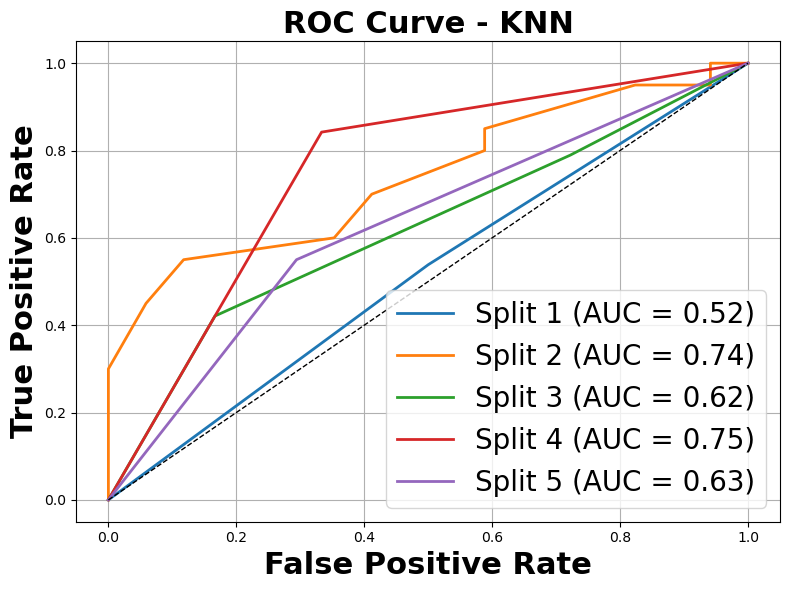

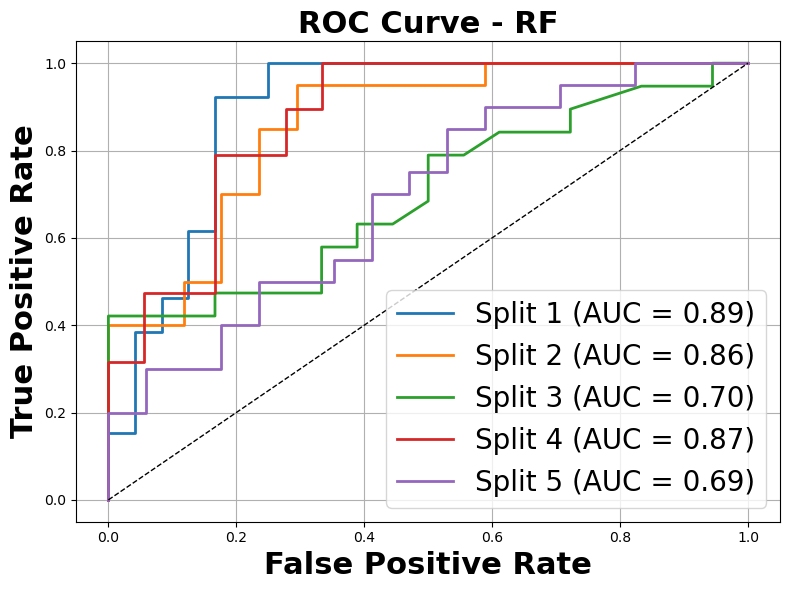

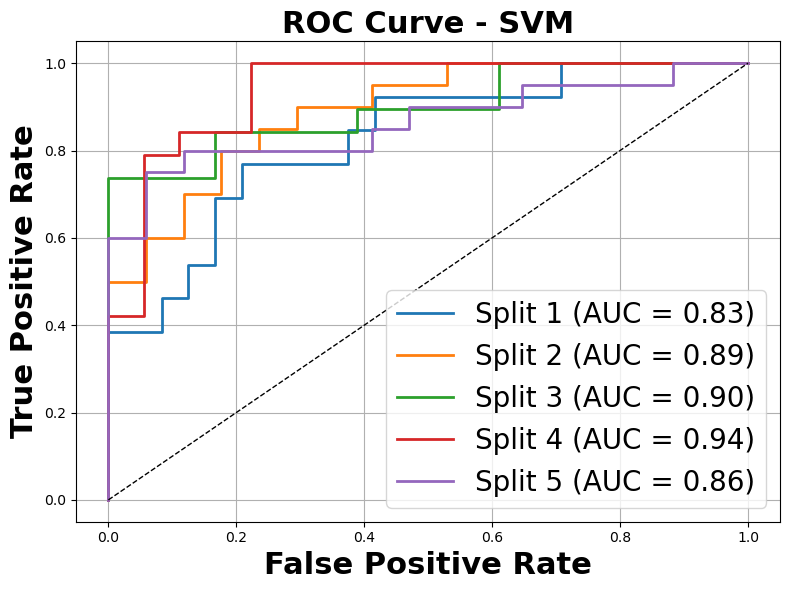

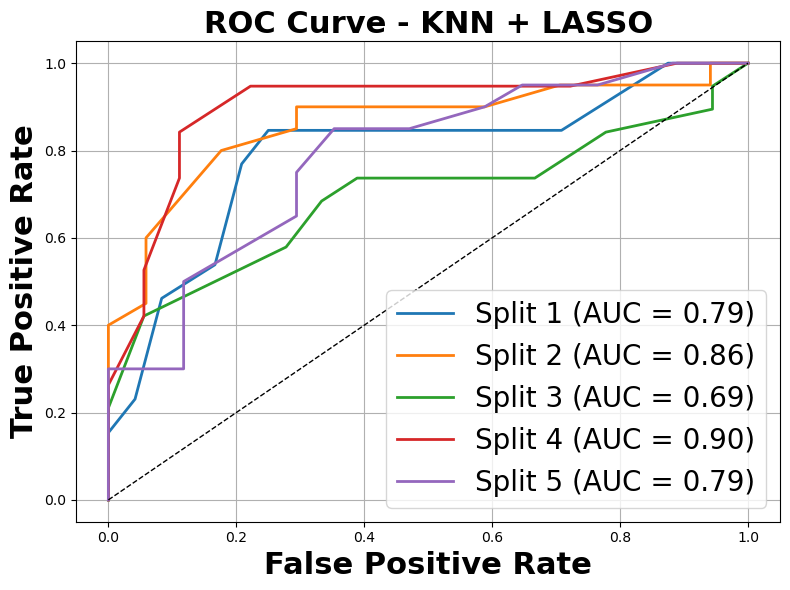

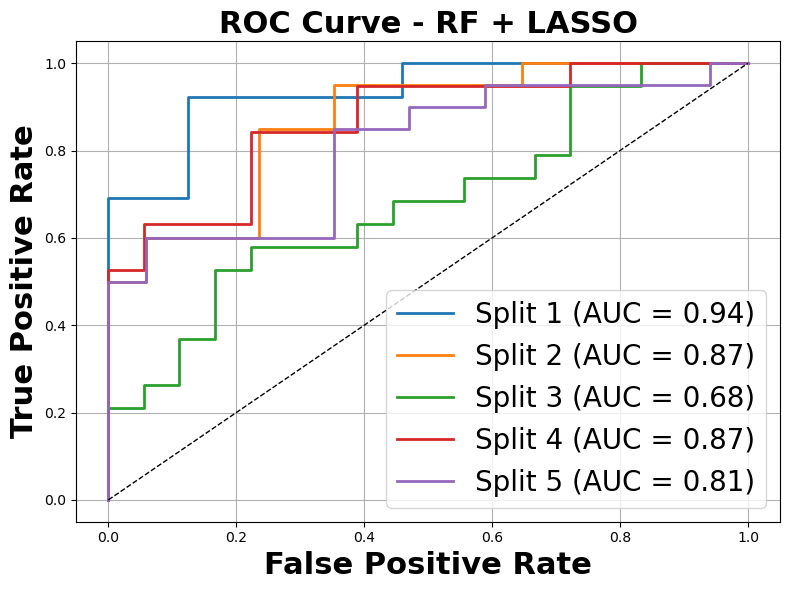

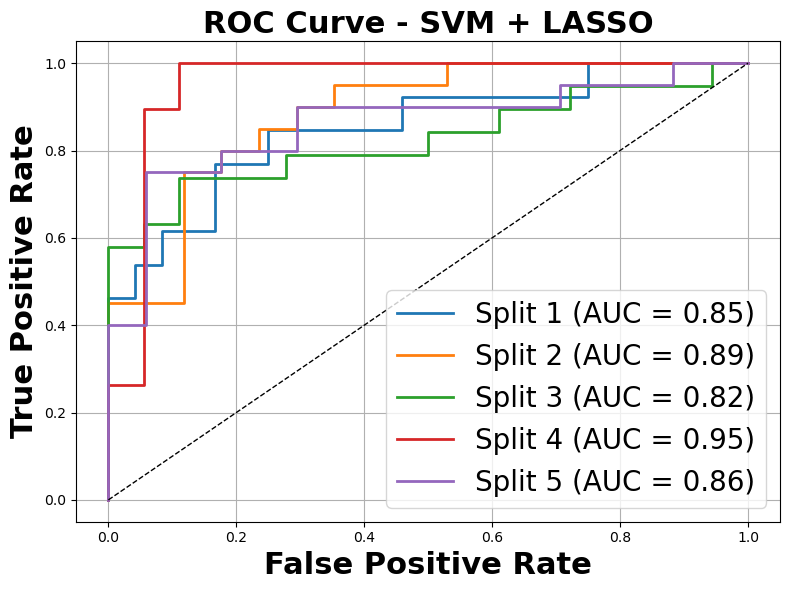

In [ ]:
#Plots of the ROC
for label, curves in roc_data.items():
    plt.figure(figsize=(8, 6))
    for i, (fpr, tpr) in enumerate(curves):
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Split {i+1} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.title(f'ROC Curve - {label}', fontsize=22, fontweight='bold')
    plt.xlabel('False Positive Rate', fontsize=22, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=22, fontweight='bold')
    plt.legend(loc='lower right', fontsize=20)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Plotting the learning curves
The learning curves are only plotted of the best performing model per classifier: so one for KNN, one for RF and one for SVM.

  Classifier type Best feature selection  Best AUC  Run Index
0             KNN              KNN_LASSO  0.900585          3
1              RF               RF_LASSO  0.935897          0
2             SVM              SVM_LASSO  0.953216          3
3
0
3
best models: {'KNN': KNeighborsClassifier(n_neighbors=27), 'RF': RandomForestClassifier(max_depth=5, min_impurity_decrease=2e-05,
                       min_samples_leaf=2, min_samples_split=3,
                       n_estimators=120, random_state=42), 'SVM': SVC(C=0.01, degree=1, kernel='linear')}
KNeighborsClassifier(n_neighbors=27)
RandomForestClassifier(max_depth=5, min_impurity_decrease=2e-05,
                       min_samples_leaf=2, min_samples_split=3,
                       n_estimators=120, random_state=42)
SVC(C=0.01, degree=1, kernel='linear')


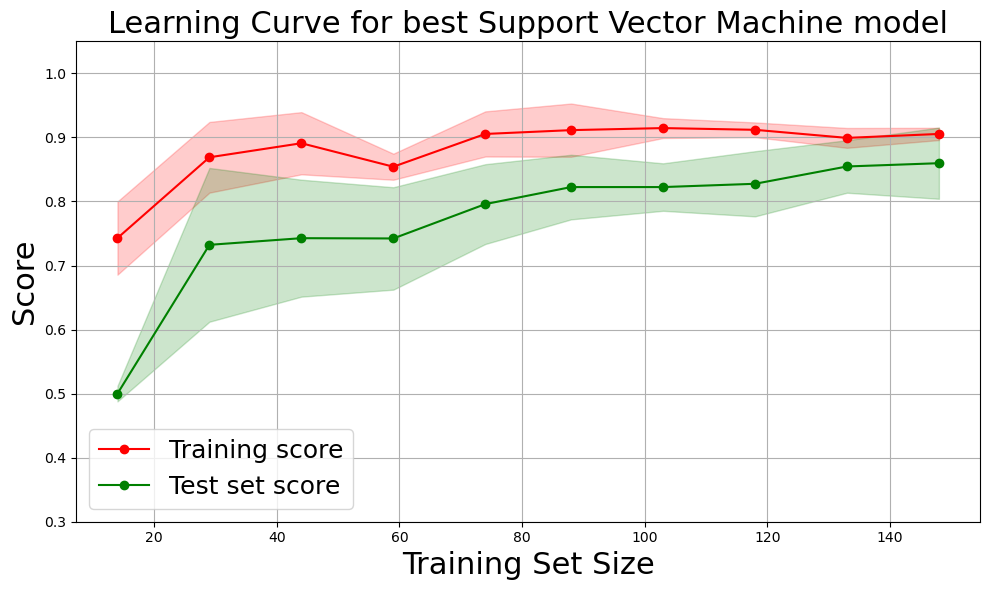

In [ ]:
model_groups = [
    ("KNN", "KNN_AUC", "KNN_LASSO_AUC"),
    ("RF", "RF_AUC", "RF_LASSO_AUC"),
    ("SVM", "SVM_AUC", "SVM_LASSO_AUC")
]

#list to save the results
best_auc_results = []

#loop per model-type (model_groups)
for group_name, column, column_lasso in model_groups:
    highest_auc = -1
    best_model = ""
    best_run = -1

    for i, (auc, auc_lasso) in enumerate(zip(results_df[column], results_df[column_lasso])):
        if auc >= auc_lasso: #when the accuracy without LASSO is higher than with LASSO, save AUC without LASSO
            auc = auc
            model = group_name
        else:                #when the accuracy with LASSO is higher than without LASSO, save AUC with LASSO
            auc = auc_lasso
            model = group_name + "_LASSO"

        if auc > highest_auc: #if this AUC is higher than the AUC's of the earlier models that are looped through, replace AUC
            highest_auc = auc
            best_model = model
            best_run = i

    #save the results of the best classifier of KNN/RF/SVM
    best_auc_results.append({
        "Classifier type": group_name,
        "Best feature selection": best_model,
        "Best AUC": highest_auc,
        "Run Index": best_run
    })

best_auc_df = pd.DataFrame(best_auc_results) #convert to dataframe
print(best_auc_df)

models_df = pd.DataFrame(stored_models) #dataframe in which hyperparameters of the models are stored

best_models = {}
features_best_model ={}
for _, row in best_auc_df.iterrows():
    group       = row["Classifier type"]            #KNN, RF or SVM
    variant     = row["Best feature selection"]     #for example: KNN or KNN_LASSO
    run_idx     = int(row["Run Index"])             #in which run this model was created

    best_models[group] = models_df.loc[run_idx, variant]
    if variant in ["KNN_LASSO", "RF_LASSO", "SVM_LASSO"]:
        features_best_model[group] = all_selected_features_LASSO[run_idx]
    else:
        features_best_model[group] = all_selected_features[run_idx]

#extract the best models, and the features that were used to train this model
best_KNN_model = best_models["KNN"]
features_best_KNN_model = features_best_model["KNN"]

best_RF_model = best_models["RF"]
features_best_RF_model = features_best_model["RF"]

best_SVM_model = best_models["SVM"]
features_best_SVM_model = features_best_model["SVM"]

print (f'best models: {best_models}')

print(best_KNN_model)
print(best_RF_model)
print(best_SVM_model)

### Preprocessing all the data together (needed for learning curves)
label_binary_lc = determining_labels(data)
full_data_clean_lc = handling_missing_data(data)
data_clean_lc = delete_no_varation(full_data_clean_lc, features_no_variation)
data_normalized_df_lc = standardize_data(data_clean_lc)

#input data of the learning curves
input_lc_KNN = data_normalized_df_lc[features_best_KNN_model]
input_lc_KNN = pd.DataFrame(input_lc_KNN)

input_lc_RF = data_normalized_df_lc[features_best_RF_model]
input_lc_RF = pd.DataFrame(input_lc_RF)

input_lc_SVM = data_normalized_df_lc[features_best_SVM_model]
input_lc_SVM = pd.DataFrame(input_lc_SVM)

#define sizes of the training set to use (10 steps from 10% to 100%)
train_sizes = np.linspace(0.1, 1.0, 10)

## KNN
#get learning curve scores
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_KNN_model,
    X=input_lc_KNN, #complete dataset after complete preprocessing
    y=label_binary_lc, #labels of the complete dataset 
    train_sizes=train_sizes,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    return_times=False
)

#calculate means and standard deviations
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

#create the plot
plt.figure(figsize=(10, 6))
plt.title(f"Learning Curve for best K-Nearest Neighbours model", fontsize = 22)
plt.plot(train_sizes, train_mean, 'o-', color="red", label="Training score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="red")
plt.plot(train_sizes, test_mean, 'o-', color="green", label="Test set score")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color="green")
plt.xlabel("Training Set Size",fontsize = 22)
plt.ylabel("Score", fontsize = 22)
plt.grid(True)
plt.legend(loc="best", fontsize = 18)
plt.ylim(0.3, 1.05)
plt.tight_layout()
plt.show()

## RF
#get learning curve scores
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_RF_model,
    X=input_lc_RF, #complete dataset after complete preprocessing
    y=label_binary_lc, #labels of the complete dataset 
    train_sizes=train_sizes,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    return_times=False
)

#calculate means and standard deviations
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

#create the plot
plt.figure(figsize=(10, 6))
plt.title(f"Learning Curve for best Random Forest model", fontsize = 22)
plt.plot(train_sizes, train_mean, 'o-', color="red", label="Training score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="red")
plt.plot(train_sizes, test_mean, 'o-', color="green", label="Test set score")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color="green")
plt.xlabel("Training Set Size",fontsize = 22)
plt.ylabel("Score", fontsize = 22)
plt.grid(True)
plt.legend(loc="best", fontsize = 18)
plt.ylim(0.3, 1.05)
plt.tight_layout()
plt.show()

## SVM
#get learning curve scores
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_SVM_model,
    X=input_lc_SVM, #complete dataset after complete preprocessing
    y=label_binary_lc, #labels of the complete dataset 
    train_sizes=train_sizes,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    return_times=False
)

#calculate means and standard deviations
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

#create the plot
plt.figure(figsize=(10, 6))
plt.title(f"Learning Curve for best Support Vector Machine model", fontsize = 22)
plt.plot(train_sizes, train_mean, 'o-', color="red", label="Training score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="red")
plt.plot(train_sizes, test_mean, 'o-', color="green", label="Test set score")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color="green")
plt.xlabel("Training Set Size",fontsize = 22)
plt.ylabel("Score", fontsize = 22)
plt.grid(True)
plt.legend(loc="best", fontsize = 18)
plt.ylim(0.3, 1.05)
plt.tight_layout()
plt.show()
